In [1]:
!export SPARK_HOME=~/workspace_linux/usr/spark-3.3.1-bin-hadoop3
!export PATH=$SPARK_HOME/bin:$PATH
!export PYTHONPATH=$SPARK_HOME/python:$PYTHONPATH:$SPARK_HOME/python/lib/py4j-0.10.9.5-src.zip
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum, col, desc, avg, row_number
from pyspark.sql.types import StructType,StructField, StringType, IntegerType
from pyspark.sql.window import Window

In [2]:
import seaborn as sns

In [3]:
spark = SparkSession.builder.master("local") \
.appName("P1") \
.getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/07 09:06:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Part 1

## Read the dataset using Apache Spark.

In [4]:
data = spark.read \
.format("csv") \
.option("inferSchema", "true") \
.option("header", "true") \
.load("data/pupil-absence-in-schools-in-england_2018-19/data/Absence_3term201819_nat_reg_la_sch.csv")
    

## Store the dataset using the methods supported by Apache Spark.

In [5]:
data.persist()

23/04/07 09:06:39 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


DataFrame[time_identifier: string, year_breakdown: string, time_period: int, geographic_level: string, country_code: string, country_name: string, region_code: string, region_name: string, old_la_code: int, new_la_code: string, la_name: string, estab: int, laestab: int, urn: string, school_type: string, academy_type: string, academy_open_date: string, all_through: string, num_schools: int, enrolments: int, sess_possible: bigint, sess_overall: int, sess_authorised: int, sess_unauthorised: int, sess_overall_percent: double, sess_authorised_percent: double, sess_unauthorised_percent: double, enrolments_pa_10_exact: int, enrolments_pa_10_exact_percent: double, sess_possible_pa_10_exact: int, sess_overall_pa_10_exact: int, sess_authorised_pa_10_exact: int, sess_unauthorised_pa_10_exact: int, sess_overall_percent_pa_10_exact: double, sess_authorised_percent_pa_10_exact: double, sess_unauthorised_percent_pa_10_exact: double, sess_auth_illness: int, sess_auth_appointments: int, sess_auth_relig

In [6]:
# constants
LA_NAMES = sorted([i for i in data.select('la_name').distinct().rdd.map(
    lambda x: x.la_name).collect() if i != None])
PERIODS = data.select('time_period').distinct().rdd.map(
    lambda x: x.time_period).collect()
SCHOOL_TYPES = data.select('school_type').distinct().rdd.map(
    lambda x: x.school_type).collect()

## Allow the user to search the dataset by the local authority, showing the number of pupil enrolments in each local authority by time period (year).
Given a list of local authorities, display in a well-formatted fashion
the number of pupil enrolments in each local authority by time period
(year).

In [8]:
print("""
Give a list of local authorities to show pupil enrolments by time period.

Type 'done' to finish querying.
""")
cont = True
while cont:
    local_authorities = input("Enter local authorities (comma separated): ").split(",")
    if local_authorities[0].lower() == "done":
        cont = False
        continue
    la_stats = data.where(col("la_name").isin(local_authorities))\
        .groupBy(["la_name", "time_period"])\
        .agg(sum("enrolments").alias("Total enrolment"))\
        .orderBy([col("la_name"), col("time_period")])\
        .select(col("la_name").alias("Local authority"), col("time_period").alias("Year"), col("Total enrolment"))
    la_stats.show(la_stats.count(), truncate=False)
    


Give a list of local authorities to show pupil enrolments by time period.

Type 'done' to finish querying.

+---------------+------+---------------+
|Local authority|Year  |Total enrolment|
+---------------+------+---------------+
|Barnet         |200607|116352         |
|Barnet         |200708|116730         |
|Barnet         |200809|117087         |
|Barnet         |200910|118167         |
|Barnet         |201011|120132         |
|Barnet         |201112|122490         |
|Barnet         |201213|125763         |
|Barnet         |201314|129498         |
|Barnet         |201415|132801         |
|Barnet         |201516|136782         |
|Barnet         |201617|141582         |
|Barnet         |201718|143292         |
|Barnet         |201819|148284         |
|Hackney        |200607|65523          |
|Hackney        |200708|65124          |
|Hackney        |200809|66039          |
|Hackney        |200910|67686          |
|Hackney        |201011|70497          |
|Hackney        |201112|73098 

## Allow the user to search the dataset by school type, showing the total number of pupils who were given authorised absences because of medical appointments or illness in the time period 2017-2018.

In [9]:
print("""
Dataset by school type, showing the total number of
authorised absences because of medical appointments
or illness in the time period 2017-2018.
""")

school_type = data.where(col("geographic_level") == "National")\
                  .where(col('time_period') == 201718)\
                  .groupBy(["school_type"])\
                  .agg(
                    sum("sess_auth_illness").alias("Illness"),
                    sum("sess_auth_appointments").alias("Appointments"),)\
                  .withColumnRenamed('school_type', 'Type')
school_type.show(school_type.count(), truncate=False)


Dataset by school type, showing the total number of
authorised absences because of medical appointments
or illness in the time period 2017-2018.

+----------------------+--------+------------+
|Type                  |Illness |Appointments|
+----------------------+--------+------------+
|Total                 |63987585|6903699     |
|Special               |1503388 |373911      |
|State-funded secondary|29018679|3379057     |
|State-funded primary  |33465518|3150731     |
+----------------------+--------+------------+



## Allow a user to search for all unauthorised absences in a certain year, broken down by either region name or local authority name.

In [11]:
print("""
Give a list of years (in the format 200910 for 2009/10).

Type 'done' to finish querying.
""")
cont = True
while cont:
    years = input("Enter year (comma separated): ").split(",")
    if years[0].lower() == "done":
        cont = False
        continue
    breakdown = input("Enter granularity ('r' or 'la'): ").lower()
    gl = ["Local authority", "la_name"] if breakdown == 'la' else ["Regional", "region_name"]
    stats = data.where(col("geographic_level") == gl[0])\
                .where(col("time_period").isin([int(y) for y in years]))\
                .groupBy([col(gl[1]), col("time_period")]).agg(
                    sum("sess_unauthorised").alias("All unauthorised absences"))\
                .orderBy([col(gl[1]), col("time_period")])\
                .withColumnRenamed(gl[1], "Name")\
                .withColumnRenamed('time_period', 'Year')
    stats.show(stats.count(), truncate=False)
    


Give a list of years (in the format 200910 for 2009/10).

Type 'done' to finish querying.

+----------------------------+------+-------------------------+
|Name                        |Year  |All unauthorised absences|
+----------------------------+------+-------------------------+
|Barking and Dagenham        |200910|230350                   |
|Barking and Dagenham        |201213|274962                   |
|Barnet                      |200910|224306                   |
|Barnet                      |201213|273214                   |
|Barnsley                    |200910|240198                   |
|Barnsley                    |201213|317228                   |
|Bath and North East Somerset|200910|125980                   |
|Bath and North East Somerset|201213|123478                   |
|Bedford                     |200910|84386                    |
|Bedford                     |201213|135756                   |
|Bexley                      |200910|228462                   |
|Bexley     

## List the top 3 reasons for authorised absences in each year.

In [38]:
from pyspark.sql.types import LongType

In [40]:
top = data.where(col("geographic_level") == "National").groupBy('time_period').agg(
    sum("sess_auth_appointments").alias("Appointments"),
    sum("sess_auth_excluded").alias("Excluded"),
    sum("sess_auth_ext_holiday").alias("Extended_holiday"),
    sum("sess_auth_holiday").alias("Holiday"),
    sum("sess_auth_illness").alias("Illness"),
    sum("sess_auth_religious").alias("Religious"),
    sum("sess_auth_study").alias("Study"),
    sum("sess_auth_traveller").alias("Travel"),
    sum("sess_auth_other").alias("Other"),
).na.fill(0).withColumn("Extended_holiday", col("Extended_holiday").cast(LongType()))

In [41]:
top_ = top.selectExpr("time_period",
"stack( {}, ".format(
    str(len(top.columns) - 1)) + \
    ", ".join(["'{i}', {i}".format(i=i) for i in top.columns[1:]]) + \
    ") as (Reason, Count)")


In [42]:
top_.show()

+-----------+----------------+---------+
|time_period|          Reason|    Count|
+-----------+----------------+---------+
|     201415|    Appointments| 14114204|
|     201415|        Excluded|  3096670|
|     201415|Extended_holiday|        0|
|     201415|         Holiday|  3467294|
|     201415|         Illness|130415222|
|     201415|       Religious|  1473162|
|     201415|           Study|  1203852|
|     201415|          Travel|   544028|
|     201415|           Other| 12392428|
|     201011|    Appointments| 12655800|
|     201011|        Excluded|  2962556|
|     201011|Extended_holiday|   347640|
|     201011|         Holiday| 14175518|
|     201011|         Illness|127293770|
|     201011|       Religious|  3400704|
|     201011|           Study|  2152702|
|     201011|          Travel|   546450|
|     201011|           Other| 13468396|
|     201819|    Appointments| 14047908|
|     201819|        Excluded|  4099944|
+-----------+----------------+---------+
only showing top

In [45]:
window = Window.partitionBy("time_period").orderBy(col("Count").desc())

# Add a row number for each row within each time_period based on the rank column
df = top_.withColumn("Rank", row_number().over(window))



In [47]:
# Filter out the top 3 highest values in each time_period
top3_illness_df = df.filter(col("rank") <= 3).select(col("time_period").alias("Year"), "Rank", "Reason", "Count")

top3_illness_df.show(truncate=False)

+------+----+------------+---------+
|Year  |Rank|Reason      |Count    |
+------+----+------------+---------+
|200607|1   |Illness     |134733002|
|200607|2   |Holiday     |23602270 |
|200607|3   |Other       |21116078 |
|200708|1   |Illness     |129433414|
|200708|2   |Holiday     |20780790 |
|200708|3   |Other       |16357850 |
|200809|1   |Illness     |134930584|
|200809|2   |Holiday     |18743040 |
|200809|3   |Other       |17024566 |
|200910|1   |Illness     |131819712|
|200910|2   |Other       |18728658 |
|200910|3   |Holiday     |15581994 |
|201011|1   |Illness     |127293770|
|201011|2   |Holiday     |14175518 |
|201011|3   |Other       |13468396 |
|201112|1   |Illness     |115473894|
|201112|2   |Holiday     |13109464 |
|201112|3   |Appointments|12840428 |
|201213|1   |Illness     |139383386|
|201213|2   |Holiday     |16529824 |
+------+----+------------+---------+
only showing top 20 rows



# Part 2

## Allow a user to compare two local authorities of their choosing in a given year.
Justify how you will compare and present the data.

In [7]:
loacal_authorities = ['Barnet',  'Hackney']
year = 201718

In [37]:
def compare(loacal_authorities, year):
    return data.where(col("geographic_level") == "Local authority")\
                .where(col("la_name").isin(loacal_authorities))\
                .where(col('time_period') == year)\
                .groupBy(["la_name", "school_type"])\
                .agg(
                    sum("num_schools").alias("Number of Schools"),
                    sum("enrolments").alias("Enrolments"),
                    sum("enrolments_pa_10_exact").alias("Number of Persistent Absentees"),
                    sum("sess_overall").alias("Overall Absence Sessions"), # Number of overall absence sessions
                    sum("sess_possible").alias("Possible Sessions"), # Number of sessions possible
                )\
                .orderBy(["la_name", "school_type"])\
                .withColumn("Average Enrolment", col("Enrolments")/col("Number of Schools"))\
                .withColumn("Overall Absence Rate (%)", 100 * col("Overall Absence Sessions")/col("Possible Sessions"))\
                .withColumn("Persistant Absentees Rate (%)", 100 * col("Number of Persistent Absentees")/col("Enrolments"))\
                .withColumnRenamed("school_type", "School Type")\
                .withColumnRenamed("la_name", "Authority")


In [38]:
sample = compare(loacal_authorities, year)

In [39]:
sample.show()

+---------+--------------------+-----------------+----------+------------------------------+------------------------+-----------------+------------------+------------------------+-----------------------------+
|Authority|         School Type|Number of Schools|Enrolments|Number of Persistent Absentees|Overall Absence Sessions|Possible Sessions| Average Enrolment|Overall Absence Rate (%)|Persistant Absentees Rate (%)|
+---------+--------------------+-----------------+----------+------------------------------+------------------------+-----------------+------------------+------------------------+-----------------------------+
|   Barnet|             Special|                5|       384|                           116|                   15817|           133284|              76.8|      11.867140842111581|           30.208333333333332|
|   Barnet|State-funded primary|               90|     26198|                          1691|                  359345|          9336896| 291.0888888888889|      

## Chart/explore the performance of regions in England from 2006-2018.
Your charts and subsequent analysis in your report should answer the
following questions:
* Are there any regions that have improved in pupil attendance over the years?
* Are there any regions that have worsened?
* Which is the overall best/worst region for pupil attendance?

In [43]:
explore = data.where(col("geographic_level") == "Regional")\
    .groupBy(["time_period","region_name", "school_type"])\
    .agg(
                sum("num_schools").alias("Number of Schools"),
                sum("enrolments").alias("Enrolments"),
                sum("enrolments_pa_10_exact").alias("Number of Persistent Absentees"),
                sum("sess_overall").alias("Overall Absence Sessions"), # Number of overall absence sessions
                sum("sess_possible").alias("Possible Sessions"), # Number of sessions possible
            )\
    .orderBy(["region_name","time_period", "school_type"])\
    .withColumn("Average Enrolment", col("Enrolments")/col("Number of Schools"))\
    .withColumn("Overall Absence Rate (%)", 100 * col("Overall Absence Sessions")/col("Possible Sessions"))\
    .withColumn("Persistant Absentees Rate (%)", 100 * col("Number of Persistent Absentees")/col("Enrolments"))\
    .withColumnRenamed("school_type", "School Type")\
    .withColumnRenamed("region_name", "Region")

In [46]:
explore.show()

+-----------+-------------+--------------------+-----------------+----------+------------------------------+------------------------+-----------------+------------------+------------------------+-----------------------------+
|time_period|       Region|         School Type|Number of Schools|Enrolments|Number of Persistent Absentees|Overall Absence Sessions|Possible Sessions| Average Enrolment|Overall Absence Rate (%)|Persistant Absentees Rate (%)|
+-----------+-------------+--------------------+-----------------+----------+------------------------------+------------------------+-----------------+------------------+------------------------+-----------------------------+
|     200607|East Midlands|             Special|               78|      5146|                          1509|                  148939|          1521438| 65.97435897435898|       9.789357173936763|           29.323746599300428|
|     200607|East Midlands|State-funded primary|             1699|    301947|                   

In [50]:
explore.where(col('School Type') == 'Total')\
       .groupBy("Region")\
       .agg(
              sum("Overall Absence Sessions").alias("Overall Absence Sessions"), # Number of overall absence sessions
              sum("Possible Sessions").alias("Possible Sessions"), # Number of sessions possible
       )\
       .withColumn("Overall Absence Rate (%)", 100 * col("Overall Absence Sessions")/col("Possible Sessions"))\
       .select("Region", "Overall Absence Rate (%)")\
       .orderBy("Overall Absence Rate (%)")\
       .limit(5).show()

+---------------+------------------------+
|         Region|Overall Absence Rate (%)|
+---------------+------------------------+
|   Outer London|      5.0186191860909215|
|   Inner London|       5.052629355067825|
|     South East|       5.185406920850401|
|  East Midlands|       5.210187029187941|
|East of England|      5.2154412707480615|
+---------------+------------------------+



In [51]:
explore.where(col('School Type') == 'Total')\
       .groupBy("Region")\
       .agg(
              sum("Overall Absence Sessions").alias("Overall Absence Sessions"), # Number of overall absence sessions
              sum("Possible Sessions").alias("Possible Sessions"), # Number of sessions possible
       )\
       .withColumn("Overall Absence Rate (%)", 100 * col("Overall Absence Sessions")/col("Possible Sessions"))\
       .select("Region", "Overall Absence Rate (%)")\
       .orderBy(col("Overall Absence Rate (%)").desc())\
       .limit(5).show()

+--------------------+------------------------+
|              Region|Overall Absence Rate (%)|
+--------------------+------------------------+
|          North East|       5.486040677235756|
|Yorkshire and the...|       5.447004417628933|
|       West Midlands|       5.317785993434155|
|          South West|       5.306503042772152|
|          North West|       5.254204572459868|
+--------------------+------------------------+



# Part 3

## Analyse whether there is a link between school type, pupil absences and the location of the school.
For example, is it more likely that schools of type X will have more pupil absences in location Y?

**Possible Session** - Schools are required to provide 2 possible sessions per day - 1 session in the morning and 1 in the afternoon. This is why a session is equivalent to half-a-day.

In [154]:
import seaborn as sns

from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler

from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

### Region Level

In [145]:
region_df = data.where(col("geographic_level") == "Regional")\
    .where(col("school_type") != "Total")\
    .groupBy(["region_name", "school_type"])\
    .agg(
    sum("num_schools").alias("Number of Schools"),
    sum("enrolments").alias("Enrolments"),
    sum("sess_overall").alias("Overall Absence Sessions"), # Number of overall absence sessions
    sum("sess_possible").alias("Possible Sessions"), # Number of sessions possible
    # sum("sess_possible_pa_10_exact") # Number of sessions possible of persistent absentees
).orderBy(["region_name"])\
    .withColumn("Average Enrolment", col("Enrolments")/col("Number of Schools"))\
    .withColumn("Overall Absence Rate (%)", 100 * col("Overall Absence Sessions")/col("Possible Sessions"))\
    .withColumnRenamed("school_type", "School Type")\
    .withColumnRenamed("region_name", "Region")

<Axes: xlabel='Overall Absence Rate (%)', ylabel='Region'>

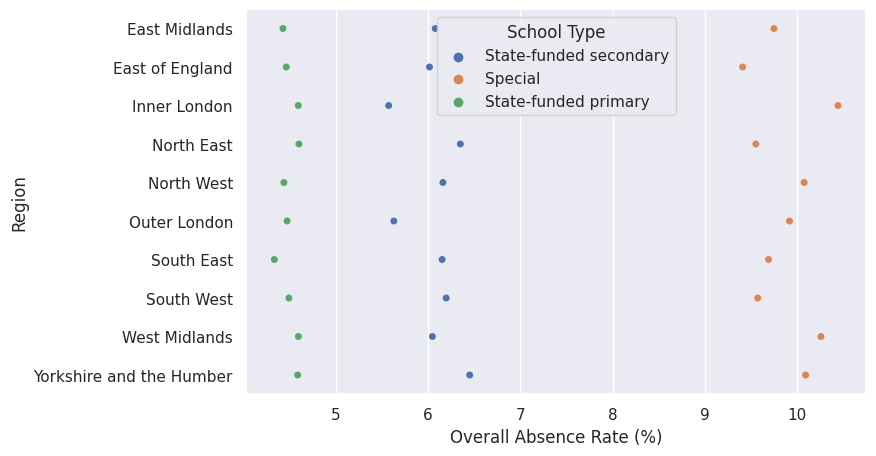

In [166]:
sns.set(rc={'figure.figsize':(8, 5)})

sns.swarmplot(y='Region', x='Overall Absence Rate (%)', hue="School Type", data=region_df.toPandas())


<Axes: xlabel='Overall Absence Rate (%)', ylabel='School Type'>

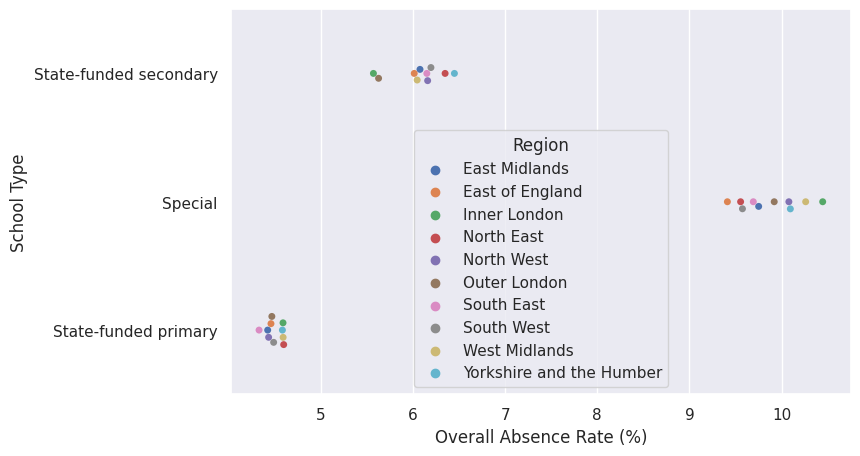

In [167]:
sns.swarmplot(y='School Type', x='Overall Absence Rate (%)', hue='Region', data=region_df.toPandas())


In [179]:
categorical_columns = ["Region", "School Type"] 

indexers = [
    StringIndexer(inputCol=c, outputCol=f"{c} Index")
    for c in categorical_columns
]

encoders = [
    OneHotEncoder(inputCol=f"{c} Index", outputCol=f"{c} Vec")
    for c in categorical_columns
]

pipeline = Pipeline(stages=indexers + encoders)
region_df_transformed = pipeline.fit(region_df).transform(region_df)


In [180]:
region_df_transformed.corr("Region Index", 'Overall Absence Rate (%)')

0.029613806849543053

In [181]:
region_df_transformed.corr("School Type Index", 'Overall Absence Rate (%)')

-0.6850752038502523

### Local Authority Level

In [153]:
la_df = data.where(col("geographic_level") == "Local authority")\
    .where(col("school_type") != "Total")\
    .groupBy(["la_name", "school_type"])\
    .agg(
    sum("num_schools").alias("Number of Schools"),
    sum("enrolments").alias("Enrolments"),
    sum("sess_overall").alias("Overall Absence Sessions"), # Number of overall absence sessions
    sum("sess_possible").alias("Possible Sessions"), # Number of sessions possible
    # sum("sess_possible_pa_10_exact") # Number of sessions possible of persistent absentees
).orderBy(["la_name"])\
    .withColumn("Average Enrolment", col("Enrolments")/col("Number of Schools"))\
    .withColumn("Overall Absence Rate (%)", 100 * col("Overall Absence Sessions")/col("Possible Sessions"))\
    .withColumnRenamed("school_type", "School Type")\
    .withColumnRenamed("la_name", "Local Authority")

<Axes: xlabel='Overall Absence Rate (%)', ylabel='Local Authority'>

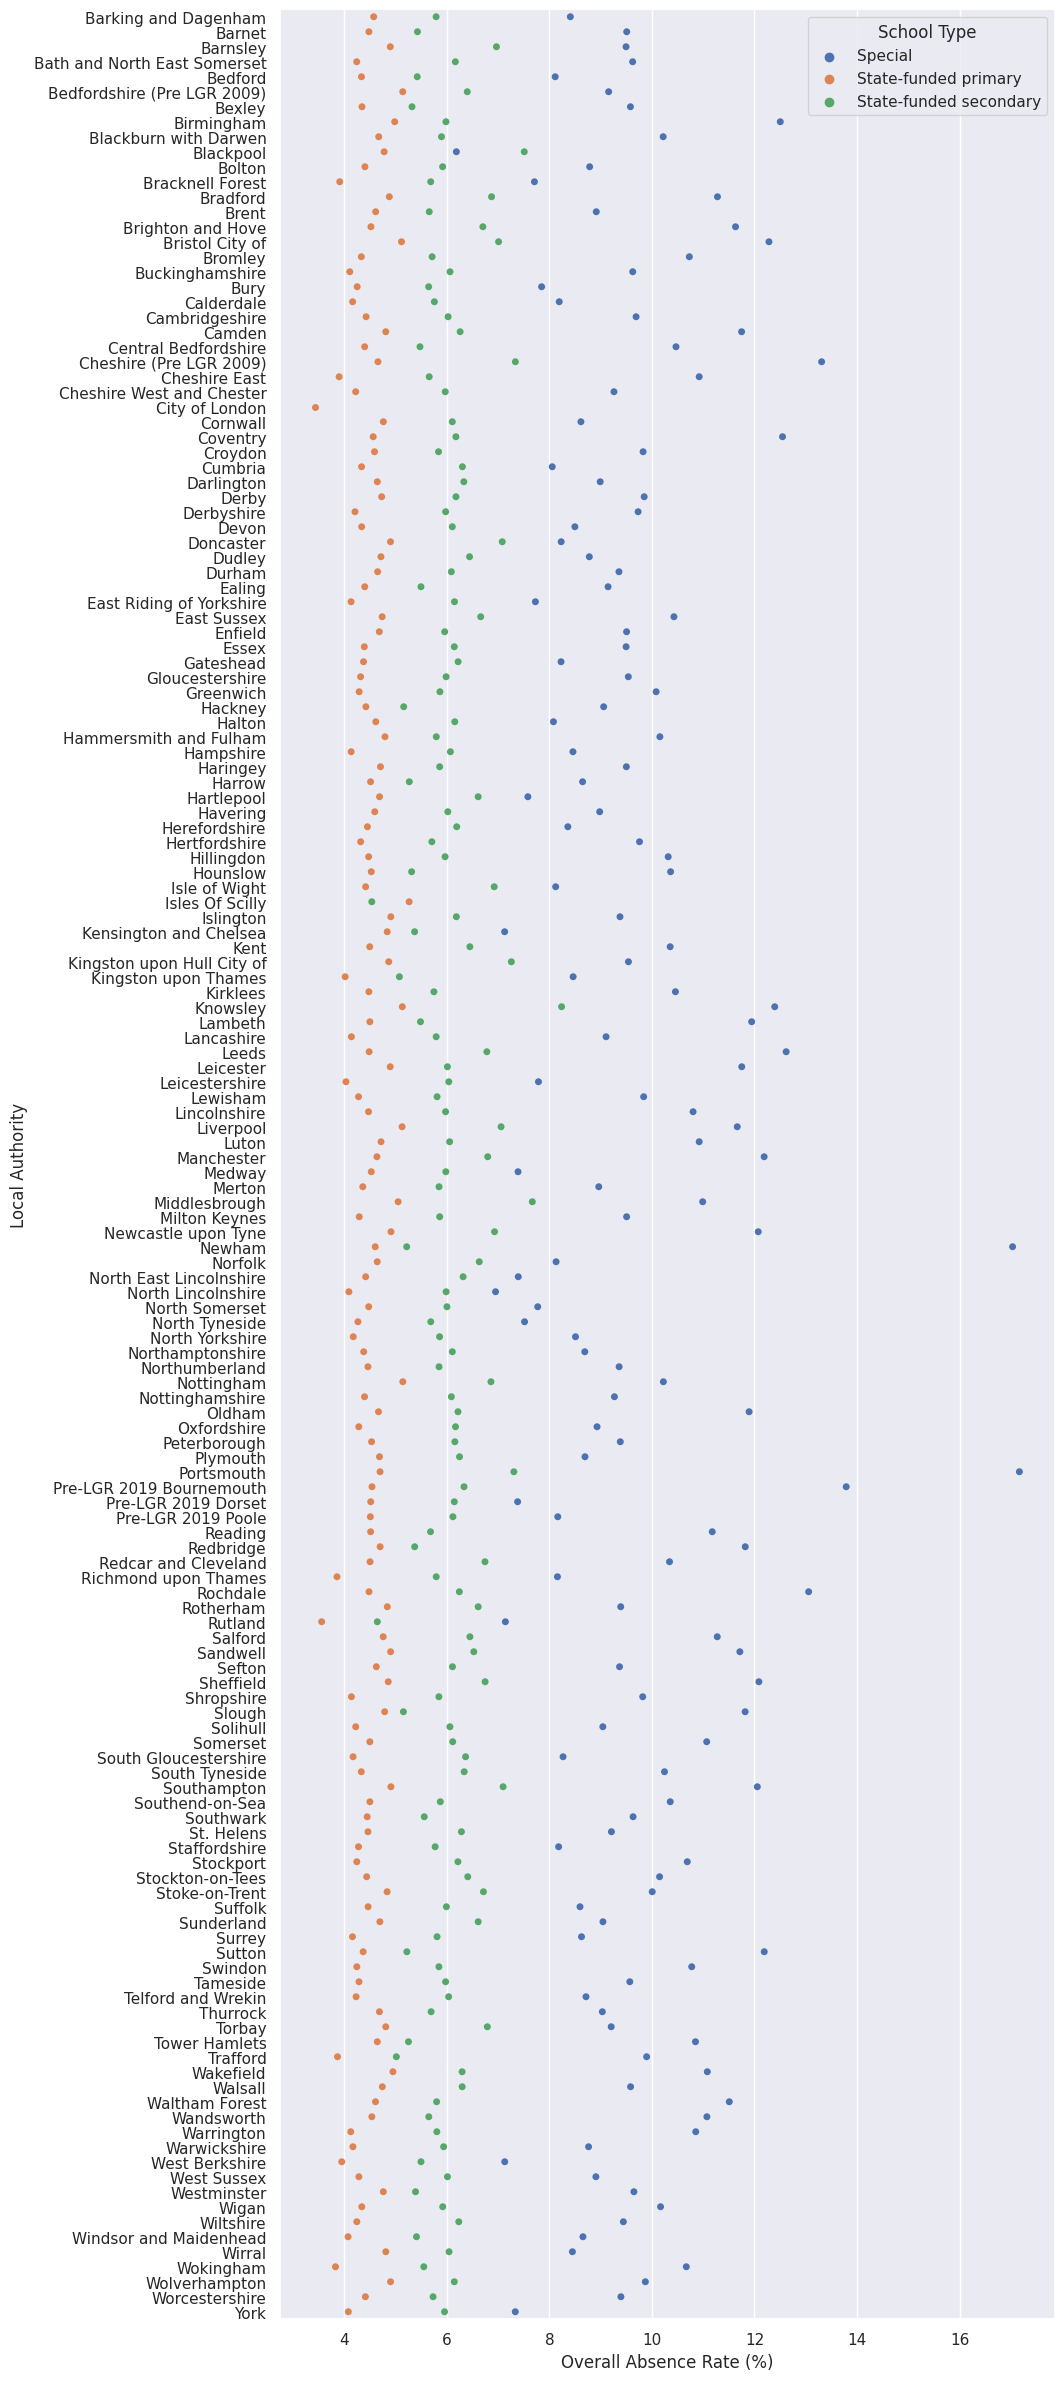

In [172]:
sns.set(rc={'figure.figsize':(10, 30)})
sns.swarmplot(y='Local Authority', x='Overall Absence Rate (%)', hue="School Type", data=la_df.toPandas())


/home/as627/.local/lib/python3.9/site-packages/seaborn/categorical.py:3544: UserWarning: 23.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/as627/.local/lib/python3.9/site-packages/seaborn/categorical.py:3544: UserWarning: 11.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<Axes: xlabel='Overall Absence Rate (%)', ylabel='School Type'>

/home/as627/.local/lib/python3.9/site-packages/seaborn/categorical.py:3544: UserWarning: 39.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/as627/.local/lib/python3.9/site-packages/seaborn/categorical.py:3544: UserWarning: 20.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


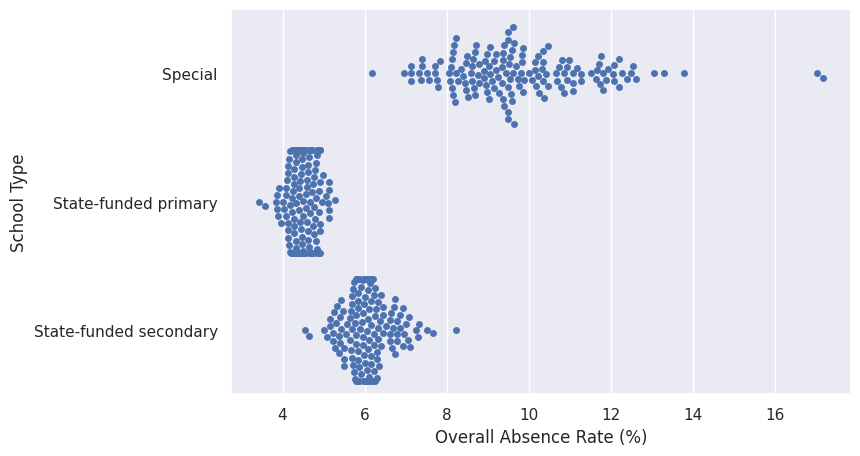

In [168]:
sns.set(rc={'figure.figsize':(8, 5)})
sns.swarmplot(y='School Type', x='Overall Absence Rate (%)', data=la_df.toPandas())

In [182]:
categorical_columns = ["Local Authority", "School Type"] 

indexers = [
    StringIndexer(inputCol=c, outputCol=f"{c} Index")
    for c in categorical_columns
]

encoders = [
    OneHotEncoder(inputCol=f"{c} Index", outputCol=f"{c} Vec")
    for c in categorical_columns
]

pipeline = Pipeline(stages=indexers + encoders)

la_df_transformed = pipeline.fit(la_df).transform(la_df)

In [183]:
la_df_transformed.corr("Local Authority Index", 'Overall Absence Rate (%)'), df_transformed.corr("School Type Index", 'Overall Absence Rate (%)')

(-0.009845684721535745, 0.8807664017645196)

## Provide school recommendations using machine learning for parents looking for a new school for their child in 2023.
Based on past data, can you predict which part of the country will provide schools with the best pupil
attendance?

In [11]:
data_institution = spark.read \
.format("csv") \
.option("inferSchema", "true") \
.option("header", "true") \
.load("data/edubasealldata20230323.csv")\
.withColumnRenamed("URN", "urn")

data_enriched = data.join(data_institution, on=["urn"], how="left")\
                    .where(col("geographic_level") == "School")\
                    .where(col("Gender (code)").isNotNull())\
                    .where(col("TypeOfEstablishment (code)").isNotNull())\
                    .where(col("PhaseOfEducation (code)").isNotNull())

# remove unnecessary columns
data = data.drop(['year_breakdown', 'academy_type', 'all_through',])

school_type_mapping = {
    "Special": 0,
    "State-funded primary": 1,
    "State-funded secondary": 2,
}

def encode_school_type(tier):
    return school_type_mapping[tier]

encode_tier_udf = udf(encode_school_type, IntegerType())

# Apply the UDF to encode the tiered categories

data_enriched = data_enriched.withColumn("school_type (code)", encode_tier_udf("school_type"))

In [29]:
data_enriched = data_enriched.drop(*[
    'time_identifier',
    'year_breakdown',
    'StatutoryLowAge',
    'StatutoryHighAge',
    'Boarders (code)',
    'Boarders (name)',
    'NurseryProvision (name)',
    'OfficialSixthForm (code)',
    'OfficialSixthForm (name)',
     'ReligiousCharacter (code)',
 'ReligiousCharacter (name)',
 'ReligiousEthos (name)',
 'Diocese (code)',
 'Diocese (name)',
 'Street',
 'Locality',
 'Address3',
 'Town',
 'County (name)',
 'Postcode',
 'SchoolWebsite',
 'TelephoneNum',
 'HeadTitle (name)',
 'HeadFirstName',
 'HeadLastName',
 'HeadPreferredJobTitle',
 'BSOInspectorateName (name)',
 'InspectorateReport',
 'DateOfLastInspectionVisit',
 'NextInspectionVisit',
 'TeenMoth (name)',
 'TeenMothPlaces',
 'CCF (name)',
 'SENPRU (name)',
 'EBD (name)',
 'PlacesPRU',
 'FTProv (name)',
 'EdByOther (name)',
 'Section41Approved (name)',
 'SEN1 (name)',
 'SEN2 (name)',
 'SEN3 (name)',
 'SEN4 (name)',
 'SEN5 (name)',
 'SEN6 (name)',
 'SEN7 (name)',
 'SEN8 (name)',
 'SEN9 (name)',
 'SEN10 (name)',
 'SEN11 (name)',
 'SEN12 (name)',
 'SEN13 (name)',
 'TypeOfResourcedProvision (name)',
 'ResourcedProvisionOnRoll',
 'ResourcedProvisionCapacity',
 'SenUnitOnRoll',
 'SenUnitCapacity',
 'GOR (code)',
 'GOR (name)',
 'DistrictAdministrative (code)',
 'DistrictAdministrative (name)',
 'AdministrativeWard (code)',
 'AdministrativeWard (name)',
 'ParliamentaryConstituency (code)',
 'ParliamentaryConstituency (name)',
 'UrbanRural (code)',
 'UrbanRural (name)',
 'GSSLACode (name)',
 'Easting',
 'Northing',
 'MSOA (name)',
 'LSOA (name)',
 'InspectorateName (name)',
 'SENStat',
 'SENNoStat',
 'BoardingEstablishment (name)',
 'PropsName',
 'PreviousLA (code)',
 'PreviousLA (name)',
 'PreviousEstablishmentNumber',
 'RSCRegion (name)',
 'Country (name)',
 'UPRN',
 'SiteName',
 'QABName (code)',
 'QABName (name)',
 'EstablishmentAccredited (code)',
 'EstablishmentAccredited (name)',
 'QABReport',
 'CHNumber',
 'MSOA (code)',
 'LSOA (code)',
])

In [12]:
PhaseOfEducation_map = {i["PhaseOfEducation (name)"]:i["PhaseOfEducation (code)"] for i in data_enriched.select("PhaseOfEducation (name)", "PhaseOfEducation (code)").distinct().collect()}
Gender_map = {i["Gender (name)"]:i["Gender (code)"] for i in data_enriched.select("Gender (name)", "Gender (code)").distinct().collect()}
TypeOfEstablishment_map = {i["TypeOfEstablishment (name)"]:i["TypeOfEstablishment (code)"] for i in data_enriched.select("TypeOfEstablishment (name)", "TypeOfEstablishment (code)").distinct().collect()}
LA_map = {i["LA (name)"]:i["LA (code)"] for i in data_enriched.select("LA (name)", "LA (code)").distinct().collect()}

In [37]:
data_enriched.groupby("LA (code), PhaseOfEducation (name), Gender (name), ")

+------+-----------+----------------+------------+------------+-----------+------------+-----------+-----------+--------------+-----+-------+--------------------+------------+-----------------+-----------+-----------+----------+-------------+------------+---------------+-----------------+--------------------+-----------------------+-------------------------+----------------------+------------------------------+-------------------------+------------------------+---------------------------+-----------------------------+--------------------------------+-----------------------------------+-------------------------------------+-----------------+----------------------+-------------------+---------------+-------------------+-----------------+---------------------+------------------+---------------+----------------------+-------------------+----------------+-----------------+-----------------+------------------------+-------------------------+---------+--------------+-------------------+------

In [33]:
data_enriched.corr("time_period", "sess_overall_percent")

-0.20662360175945402

In [13]:
import plotly.express as px

In [14]:
nested_pie_data = data_enriched.groupBy(["school_type", "TypeOfEstablishment (name)",])\
             .agg(
                sum("enrolments").alias("Total Enrolments")
             ).toPandas()

In [19]:
# import plotly.graph_objects as go

# fig=go.Figure(go.Sunburst(
#     labels=nested_pie_data['TypeOfEstablishment (name)'],
#     parents=nested_pie_data['school_type'],
#     values=nested_pie_data['Total Enrolments'],
# ))
# # fig.update_layout(margin = dict(t=0, l=0, r=0, b=0))

fig = px.sunburst(nested_pie_data, path=['school_type', 'TypeOfEstablishment (name)'], values='Total Enrolments')


fig.show()

In [38]:
to_encode = ["school_type", 'LA', 'TypeOfEstablishment', 'PhaseOfEducation', 'Gender']

encoders = [
    OneHotEncoder(inputCol=f"{c} (code)", outputCol=f"{c} Vec")
    for c in to_encode
]

feature_columns = [f"{c} Vec" for  c in to_encode]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")


In [39]:
train_data, test_data = data_enriched.randomSplit([0.8, 0.2], seed=42)


In [40]:
lr = LinearRegression(featuresCol="features", labelCol="sess_overall_percent")


In [41]:
pipeline = Pipeline(stages=[ *encoders, assembler, lr])


In [42]:
# Define the grid of hyperparameters
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01, 0.001]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Define the evaluator
evaluator = RegressionEvaluator(labelCol="sess_overall_percent", predictionCol="prediction", metricName="rmse")

# Perform cross-validation
cross_validator = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5
)

cv_model = cross_validator.fit(train_data)

### Defining the scope

I am setting the model's target variable to be the attendence rate.
Since model will predict the attendence rate, the reccommended school will be the one with lowest attendence rate.



### Extra Data

In [163]:
data_institution = spark.read \
.format("csv") \
.option("inferSchema", "true") \
.option("header", "true") \
.load("data/edubasealldata20230323.csv")\
.withColumnRenamed("URN", "urn")

data_enriched = data.join(data_institution, on=["urn"], how="left")

### Data Cleaning

In [236]:
data_enriched = data_enriched.where(col("geographic_level") == "School")

In [237]:
data_enriched = data_enriched.where(col("Gender (code)").isNotNull())\
             .where(col("TypeOfEstablishment (code)").isNotNull())\
             .where(col("PhaseOfEducation (code)").isNotNull())

In [9]:
from pyspark.ml.stat import ChiSquareTest, Correlation

In [20]:
data_enriched.select("OfstedRating (name)").distinct().show()

+--------------------+
| OfstedRating (name)|
+--------------------+
|                null|
|         Outstanding|
|  Serious Weaknesses|
|                Good|
|Requires improvement|
|    Special Measures|
+--------------------+



In [10]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

In [65]:


# Define the mapping for the categories
ofsted_mapping = {
    "Outstanding": 5,
    "Good": 4,
    "Requires improvement": 3,
    "Serious Weaknesses": 2,
    "Special Measures": 1,
    "Unrated": 0
}

# Create a User-Defined Function (UDF) to apply the mapping
def encode_tier(tier):
    return ofsted_mapping[tier]

encode_tier_udf = udf(encode_tier, IntegerType())

# Apply the UDF to encode the tiered categories
data_enriched = data_enriched.withColumn("Ofsted Rating", encode_tier_udf("OfstedRating (name)"))


In [233]:
## Feature selection
categorical_columns = ["school_type"] 

indexers = [
    StringIndexer(inputCol=c, outputCol=f"{c} (code)")
    for c in categorical_columns
]

to_encode = ["school_type", 'LA', 'TypeOfEstablishment', 'PhaseOfEducation', 'Gender']

encoders = [
    OneHotEncoder(inputCol=f"{c} (code)", outputCol=f"{c} Vec")
    for c in to_encode
]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Assemble the feature vector
feature_columns = ["time_period"] + [f"{c} Vec" for c in to_encode]

pipeline = Pipeline(stages=indexers + encoders)



In [234]:
data_enriched_transformed = pipeline.fit(data_enriched).transform(data_enriched)

23/04/07 03:22:50 WARN Executor: Managed memory leak detected; size = 80413312 bytes, task 0.0 in stage 1167.0 (TID 22845)


ERROR:root:KeyboardInterrupt while sending command.][Stage 1179:> (0 + 0) / 1]  
Traceback (most recent call last):
  File "/home/as627/workspace_linux/usr/spark-3.3.1-bin-hadoop3/python/lib/py4j-0.10.9.5-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/as627/workspace_linux/usr/spark-3.3.1-bin-hadoop3/python/lib/py4j-0.10.9.5-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib64/python3.9/socket.py", line 704, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
# Assemble the features into a single vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data_assembled = assembler.setHandleInvalid("skip").transform(data_enriched_transformed)

ERROR:root:KeyboardInterrupt while sending command.][Stage 1169:> (0 + 0) / 1]
Traceback (most recent call last):
  File "/home/as627/workspace_linux/usr/spark-3.3.1-bin-hadoop3/python/lib/py4j-0.10.9.5-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/as627/workspace_linux/usr/spark-3.3.1-bin-hadoop3/python/lib/py4j-0.10.9.5-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib64/python3.9/socket.py", line 704, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [212]:
data_assembled.corr("Gender (code)", "sess_overall_percent")

-0.1050691399713045

In [213]:
data_assembled.corr("enrolments", "sess_overall_percent")

0.06104127544122165

In [214]:
data_assembled.select("features", "sess_overall_percent").show()

+--------------------+--------------------+
|            features|sess_overall_percent|
+--------------------+--------------------+
|(1002,[0,1,2,3,4,...|             2.64531|
|(1002,[0,1,2,3,4,...|             4.25631|
|(1002,[0,1,2,3,4,...|             3.82719|
|(1002,[0,1,2,3,4,...|             4.56834|
|(1002,[0,1,2,3,4,...|             4.23316|
|(1002,[0,1,2,3,4,...|              3.7763|
|(1002,[0,1,2,3,4,...|             4.33876|
|(1002,[0,1,2,3,4,...|             4.67868|
|(1002,[0,1,2,3,4,...|             3.95477|
|(1002,[0,1,2,3,4,...|             5.11342|
|(1002,[0,1,2,3,4,...|             3.98302|
|(1002,[0,1,2,3,4,...|             4.94463|
|(1002,[0,1,2,3,4,...|             4.84276|
|(1002,[0,1,2,3,4,...|             4.52914|
|(1002,[0,1,2,3,4,...|             4.70548|
|(1002,[0,1,2,3,4,...|               4.799|
|(1002,[0,1,2,3,4,...|             4.23815|
|(1002,[0,1,2,3,4,...|             3.72774|
|(1002,[0,1,2,3,4,...|             3.72583|
|(1002,[0,1,2,3,4,...|          

In [215]:
train_data, test_data = data_assembled.select("features", "sess_overall_percent").randomSplit([0.8, 0.2], seed=0)


In [217]:
lr = LinearRegression(featuresCol="features", labelCol="sess_overall_percent")

paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01, 0.001]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()
# Define the evaluator
evaluator = RegressionEvaluator(labelCol="sess_overall_percent", predictionCol="prediction", metricName="rmse")

# Perform cross-validation
cross_validator = CrossValidator(
    estimator=lr,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5
)

cv_model = cross_validator.fit(train_data)

23/04/07 03:02:24 WARN InstanceBuilder$JavaBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
23/04/07 03:02:24 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/04/07 03:02:24 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [218]:
predictions = cv_model.transform(test_data)

# Evaluate the best model
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data =", rmse)

Root Mean Squared Error (RMSE) on test data = 1.491194953331123


In [240]:
best_model = cv_model.bestModel
best_model.save("ml_model/best_model")

ConnectionRefusedError: [Errno 111] Connection refused

In [ ]:
from pyspark.sql import Row

# Create a Row object with the same column names as your original dataset
# Replace the values with the data you want to predict
new_data = Row(time_period=202324, feature2=value2, categorical_col="category_value", attendance_rate=None) 

# Create a DataFrame with the new data
new_data_df = spark.createDataFrame([new_data])

In [230]:
cv_model.bestModel

AttributeError: 'PipelineModel' object has no attribute 'coefficients'

In [221]:
# Calculate correlation (Pearson or Spearman)
correlation_matrix = Correlation.corr(data_assembled, "features", method="spearman").collect()[0][0]

# Get the correlation values for each feature
correlations = [(feature_columns[i], correlation_matrix[i, -1]) for i in range(len(feature_columns))]

# Sort the features by their absolute correlation with the target variable
sorted_features = sorted(correlations, key=lambda x: abs(x[1]), reverse=True)

# Select the top k features
top_k_features = [feature for feature, _ in sorted_features[:k]]

ERROR:root:KeyboardInterrupt while sending command.                 (0 + 1) / 1]
Traceback (most recent call last):
  File "/home/as627/workspace_linux/usr/spark-3.3.1-bin-hadoop3/python/lib/py4j-0.10.9.5-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/as627/workspace_linux/usr/spark-3.3.1-bin-hadoop3/python/lib/py4j-0.10.9.5-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib64/python3.9/socket.py", line 704, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

### Linear Regression

#### Region Level

In [184]:
assembler = VectorAssembler(inputCols=["Region Vec", "School Type Vec", "Average Enrolment"], outputCol="features")
region_df_assembled = assembler.transform(region_df_transformed)

In [185]:
lr = LinearRegression(featuresCol="features", labelCol="Overall Absence Rate (%)")
region_model = lr.fit(region_df_assembled)

23/04/06 22:24:44 WARN Instrumentation: [0175e855] regParam is zero, which might cause numerical instability and overfitting.


: 

In [ ]:
predictions = model.transform(df_assembled)
predictions.show()

+---------------+--------------------+-----------------+----------+------------------------+-----------------+------------------+------------------------+----------------+----------------+--------------+--------------+--------------------+------------------+
|    region_name|         school_type|Number of Schools|Enrolments|Overall Absence Sessions|Possible Sessions| Average Enrolment|Overall Absence Rate (%)|region_nameIndex|school_typeIndex|region_nameVec|school_typeVec|            features|        prediction|
+---------------+--------------------+-----------------+----------+------------------------+-----------------+------------------+------------------------+----------------+----------------+--------------+--------------+--------------------+------------------+
|  East Midlands|State-funded seco...|             3838|   3323274|                65552420|       1078695041| 865.8869202709744|      6.0770113431901835|             0.0|             2.0| (9,[0],[1.0])|     (2,[],[])|(12,[

In [ ]:
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Overall Absence Rate (%)", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"RMSE: {rmse}")

RMSE: 0.21057077193610274


### Local Authority Level

In [ ]:
la_df = data.where(col("geographic_level") == "Local authority")\
    .where(col("school_type") != "Total")\
    .groupBy(["la_name", "school_type"])\
    .agg(
    sum("num_schools").alias("Number of Schools"),
    sum("enrolments").alias("Enrolments"),
    sum("sess_overall").alias("Overall Absence Sessions"), # Number of overall absence sessions
    sum("sess_possible").alias("Possible Sessions"), # Number of sessions possible
    # sum("sess_possible_pa_10_exact") # Number of sessions possible of persistent absentees
).orderBy(["la_name"])\
    .withColumn("Average Enrolment", col("Enrolments")/col("Number of Schools"))\
    .withColumn("Overall Absence Rate (%)", 100 * col("Overall Absence Sessions")/col("Possible Sessions"))\
    .withColumnRenamed("school_type", "School Type")\
    .withColumnRenamed("la_name", "Local Authority")

<Axes: xlabel='Overall Absence Rate (%)', ylabel='Local Authority'>

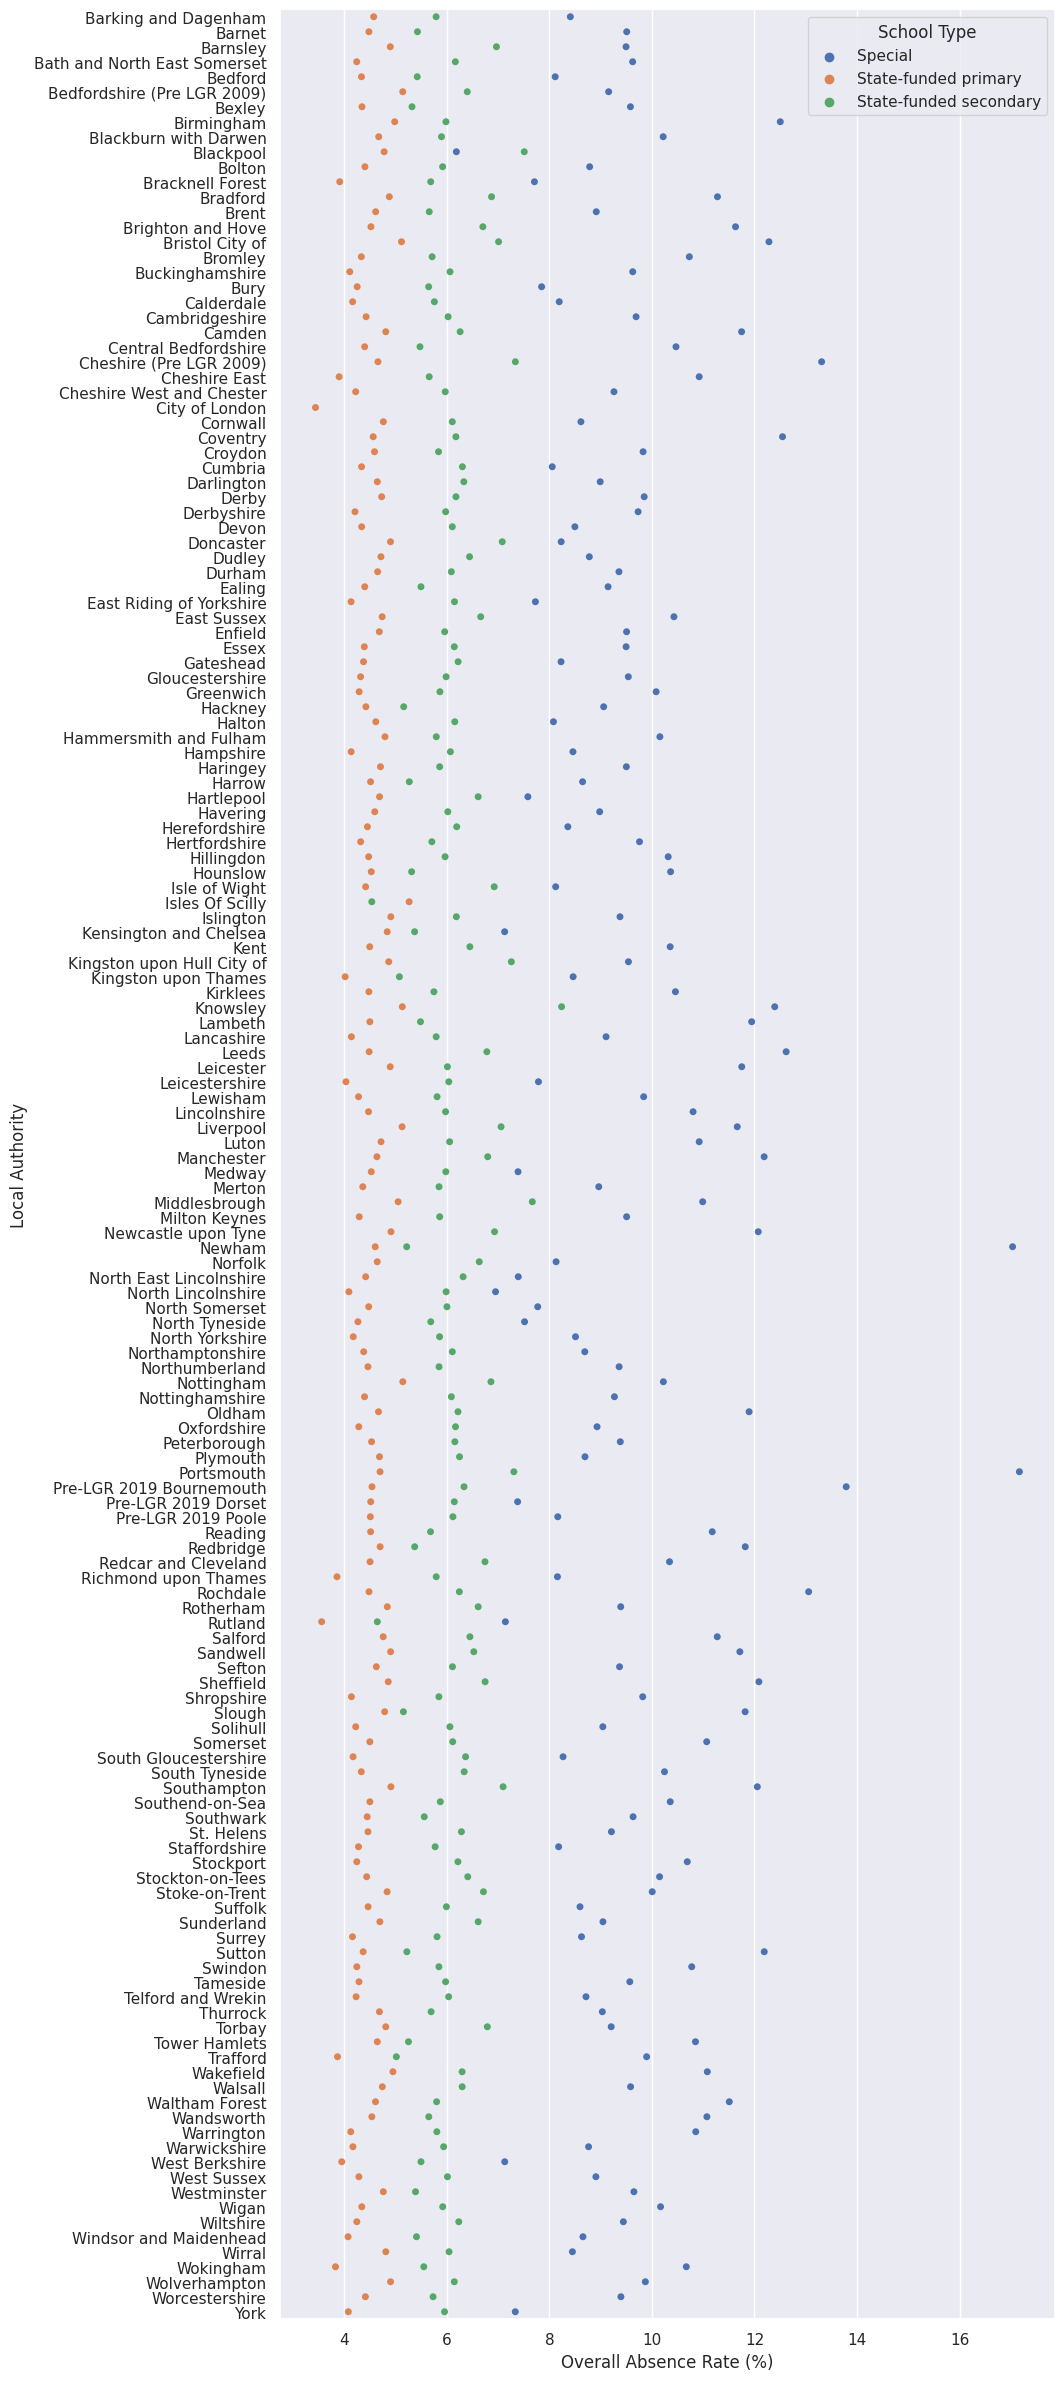

In [ ]:
sns.set(rc={'figure.figsize':(10, 30)})
sns.swarmplot(y='Local Authority', x='Overall Absence Rate (%)', hue="School Type", data=la_df.toPandas())


/home/as627/.local/lib/python3.9/site-packages/seaborn/categorical.py:3544: UserWarning: 23.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/as627/.local/lib/python3.9/site-packages/seaborn/categorical.py:3544: UserWarning: 11.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<Axes: xlabel='Overall Absence Rate (%)', ylabel='School Type'>

/home/as627/.local/lib/python3.9/site-packages/seaborn/categorical.py:3544: UserWarning: 39.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/as627/.local/lib/python3.9/site-packages/seaborn/categorical.py:3544: UserWarning: 20.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


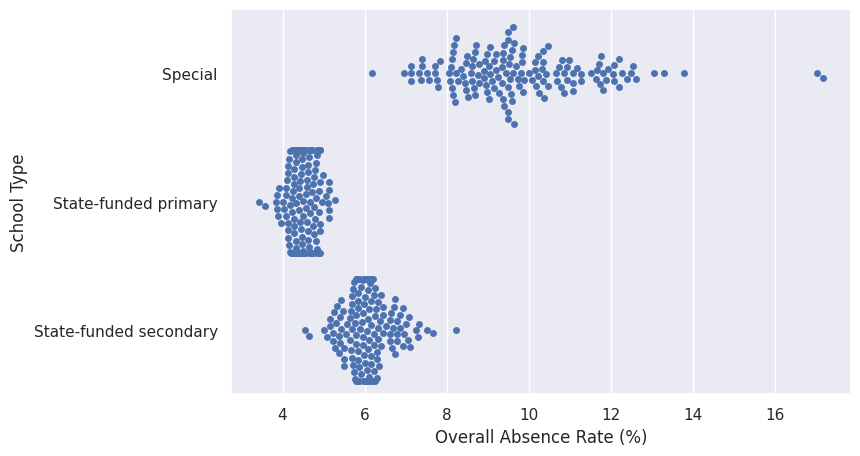

In [ ]:
sns.set(rc={'figure.figsize':(8, 5)})
sns.swarmplot(y='School Type', x='Overall Absence Rate (%)', data=la_df.toPandas())

In [ ]:
categorical_columns = ["Local Authority", "School Type"] 

indexers = [
    StringIndexer(inputCol=c, outputCol=f"{c} Index")
    for c in categorical_columns
]

encoders = [
    OneHotEncoder(inputCol=f"{c} Index", outputCol=f"{c} Vec")
    for c in categorical_columns
]

pipeline = Pipeline(stages=indexers + encoders)
df_transformed = pipeline.fit(la_df).transform(la_df)

In [ ]:
df_transformed.show()

+--------------------+--------------------+-----------------+----------+------------------------+-----------------+------------------+------------------------+---------------------+-----------------+-------------------+---------------+
|     Local Authority|         School Type|Number of Schools|Enrolments|Overall Absence Sessions|Possible Sessions| Average Enrolment|Overall Absence Rate (%)|Local Authority Index|School Type Index|Local Authority Vec|School Type Vec|
+--------------------+--------------------+-----------------+----------+------------------------+-----------------+------------------+------------------------+---------------------+-----------------+-------------------+---------------+
|Barking and Dagenham|             Special|               17|      2996|                   85599|          1017893|176.23529411764707|        8.40943006779691|                  0.0|              2.0|    (153,[0],[1.0])|      (2,[],[])|
|Barking and Dagenham|State-funded primary|             

# Extra Data

In [33]:
data_institution.printSchema()

root
 |-- urn: integer (nullable = true)
 |-- LA (code): integer (nullable = true)
 |-- LA (name): string (nullable = true)
 |-- EstablishmentNumber: integer (nullable = true)
 |-- EstablishmentName: string (nullable = true)
 |-- TypeOfEstablishment (code): integer (nullable = true)
 |-- TypeOfEstablishment (name): string (nullable = true)
 |-- EstablishmentTypeGroup (code): integer (nullable = true)
 |-- EstablishmentTypeGroup (name): string (nullable = true)
 |-- EstablishmentStatus (code): integer (nullable = true)
 |-- EstablishmentStatus (name): string (nullable = true)
 |-- ReasonEstablishmentOpened (code): integer (nullable = true)
 |-- ReasonEstablishmentOpened (name): string (nullable = true)
 |-- OpenDate: string (nullable = true)
 |-- ReasonEstablishmentClosed (code): integer (nullable = true)
 |-- ReasonEstablishmentClosed (name): string (nullable = true)
 |-- CloseDate: string (nullable = true)
 |-- PhaseOfEducation (code): integer (nullable = true)
 |-- PhaseOfEducation (

In [ ]:
OfstedRating (name)
OfstedSpecialMeasures (name)
SchoolCapacity
AdmissionsPolicy (code)
Gender (code)

PhaseOfEducation (code)

EstablishmentStatus (name) == 'Open'

EstablishmentTypeGroup (code)
TypeOfEstablishment (code)

In [36]:
data_enriched.where(col("geographic_level") == "School").show()

+------+---------------+--------------+-----------+----------------+------------+------------+-----------+------------+-----------+-----------+--------------+-----+-------+--------------------+-------------------+-----------------+-----------+-----------+----------+-------------+------------+---------------+-----------------+--------------------+-----------------------+-------------------------+----------------------+------------------------------+-------------------------+------------------------+---------------------------+-----------------------------+--------------------------------+-----------------------------------+-------------------------------------+-----------------+----------------------+-------------------+---------------+-------------------+-----------------+---------------------+------------------+---------------+----------------------+-------------------+----------------+-----------------+-----------------+------------------------+-------------------------+---------+---